In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

def dataframe(dir):
    tn_file = []
    for f_name in os.listdir(dir):
        f = os.path.join(dir, f_name)
        if f.endswith('.json'):
            tn_file.append(f)

    tn_file.sort(key=lambda f: int(re.sub('\D', '', f)))
    data = []
    for name in tn_file:
        with open(name) as json_data:
            data_dict = json.load(json_data)
            data.append(data_dict)

    d_frame = json_normalize(data)
    train_set_text = []
    for f_name in os.listdir(dir):
        f = os.path.join(dir, f_name)
        if f.endswith('.txt'):
            train_set_text.append(f)

    train_set_text.sort(key=lambda f: int(re.sub('\D', '', f)))
    text_list = []
    for file in train_set_text:
        with open(file,encoding="utf8") as f:
            content = f.read()
            text_list.append(content)

    d_frame['input_text'] = text_list

    splitted_text = []
    for text in d_frame['input_text']:
        split = text.splitlines()
        splitted_text.append(split)

    d_frame['splitted_text'] = pd.Series(splitted_text)
    for i in range(len(d_frame.index)):
        if len(d_frame['splitted_text'].iloc[i]) != len(d_frame['paragraph-authors'].iloc[i]):
            print("we have a problem at row: ",i)
    return d_frame


#data inspection
def data_inspection(data, wordCloud : bool = False):
    print(f"Dataset size: {data.shape}")
    print(f"Dataset columns: {data.columns.values}")
    print(f"Main sources: {data['site'].unique()}")
    print(f"Number of questions per source:\n {data.groupby(['site'])['site'].count()}")
    print(f"Average length of the text: {data['input_text'].apply(len).mean()}")
    print(f"Possible number of authors: {data['authors'].unique()}")
    if wordCloud:
        wordcloud = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(data['input_text']))
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud)
        plt.axis("off");
        plt.show()

#data_inspection(d_frame)
# Figures folder.
figures_path = os.path.join(os.getcwd(), "figures")
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

# Plots classes distribution.
def plot_classes_distribution(classes, counts, f_name, figures_path = figures_path):
    # Width of each bar.
    bar_w = 0.45

  # Plot.
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    bars = ax.bar(classes[0] - bar_w / 2, counts[0], width = bar_w, label = "Without preprocessing")
    bars = ax.bar(classes[1] + bar_w / 2, counts[1], width = bar_w, label = "With preprocessing")

  # Setting plot attributes.
    ax.set_xlabel("Class")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(np.arange(0, len(classes[0]), 1))
    ax.legend()

    fig.savefig(f"{figures_path}/{f_name}.pdf", bbox_inches = "tight")
    plt.show()

def preprocess_with_data_augmentation(documents, authors, tokenizer, max_length, total_upsampling = False, max_samples = None):
    # Tensors to be fed to a model.
    token_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []

  # Splitting data.
    for document, author in zip(documents, authors):
        for i in range(len(document)):
            # Checking data augmentation type.
            if total_upsampling:
                start = 0
            else:
                start = i + 1

            for j in range(start, len(document)):
                if i != j:
                    encoding_dict = tokenizer.encode_plus(document[i],
                                                document[j],
                                                add_special_tokens = True,
                                                truncation = True,
                                                padding = "max_length",
                                                max_length = max_length,
                                                return_attention_mask = True,
                                                return_token_type_ids = True,
                                                return_tensors = "tf")
                token_ids.append(encoding_dict["input_ids"])
                attention_masks.append(encoding_dict["attention_mask"])
                token_type_ids.append(encoding_dict["token_type_ids"])

                if author[i] != author[j]:
                    labels.append(1)
                else:
                    labels.append(0)

     # Creating TensorFlow tensors.
    token_ids = tf.concat(token_ids, axis = 0)
    attention_masks = tf.concat(attention_masks, axis = 0)
    token_type_ids = tf.concat(token_type_ids, axis = 0)
    labels = tf.concat(labels, axis = 0)

  # Sampling from tensors to select max_samples samples.
    if max_samples != None:
        idx = []
        idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
        idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
        token_ids = token_ids.numpy()[idx]
        attention_masks = attention_masks.numpy()[idx]
        token_type_ids = token_type_ids.numpy()[idx]
        labels = labels.numpy()[idx]

  # Returning tensors.

    return token_ids, labels, attention_masks, token_type_ids


def preprocess_without_data_augmentation(splitted_text, changes, tokenizer, max_length, max_samples = None):
    # Tensors to be fed to the model.
    token_ids = []
    attention_masks = []
    token_type_ids = []
    labels = tf.convert_to_tensor([item for sublist in changes for item in sublist])

    # Splitting data.
    for document in splitted_text:
        for i in range(len(document)):
            if i < len(document) - 1:
                encoding_dict = tokenizer.encode_plus(document[i],
                                              document[i + 1],
                                              add_special_tokens = True,
                                              truncation = True,
                                              padding = "max_length",
                                              max_length = max_length,
                                              return_attention_mask = True,
                                              return_token_type_ids = True,
                                              return_tensors = "tf")

                token_ids.append(encoding_dict["input_ids"])
                attention_masks.append(encoding_dict["attention_mask"])
                token_type_ids.append(encoding_dict["token_type_ids"])

    # Creating TensorFlow tensors.
    token_ids = tf.concat(token_ids, axis = 0)
    attention_masks = tf.concat(attention_masks, axis = 0)
    token_type_ids = tf.concat(token_type_ids, axis = 0)

  # Sampling from tensors to select max_samples samples.
    if max_samples != None:
        idx = []
        idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
        idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
        token_ids = token_ids.numpy()[idx]
        attention_masks = attention_masks.numpy()[idx]
        token_type_ids = token_type_ids.numpy()[idx]
        labels = labels.numpy()[idx]

  # Returning tensors.
    return token_ids, labels, attention_masks, token_type_ids

def create_bert_model(encoder, input_shape, n_classes, layers, fine_tune=False, dropout_rate=0.2, l2_penalty=0.001):
    # Input layers
    input_ids = tf.keras.layers.Input(shape=input_shape, name="input_ids", dtype="int32")
    masks = tf.keras.layers.Input(shape=input_shape, name="attention_masks", dtype="int32")
    token_type_ids = tf.keras.layers.Input(shape=input_shape, name="token_type_ids", dtype="int32")

    # Tensor 0 is last_hidden_state
    embeddings = encoder(input_ids, attention_mask=masks, token_type_ids=token_type_ids)[0]

    # Fine-tuning BERT
    if fine_tune:
        encoder.trainable = True

    # Adding layers
    X = embeddings
    for layer in layers:
        X = layer(X)
        if dropout_rate > 0:
            X = tf.keras.layers.Dropout(dropout_rate)(X)

    # Classification head
    X = tf.keras.layers.Flatten()(X)
    if l2_penalty > 0:
        X = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_penalty))(X)
    y = tf.keras.layers.Dense(n_classes, activation="softmax", name="outputs")(X)

    # Model
    model = tf.keras.Model(inputs=[input_ids, masks, token_type_ids], outputs=y)

    # # Compile model
    # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


    return model


# Learning rate schedule.
class LearningRateSchedule(tf.keras.callbacks.Callback):
    # Constructor.
    def __init__(self, model, n, reduction):
        self.model = model
        self.n = n
        self.reduction = reduction

  # Initializes step attribute.
    def on_train_begin(self, logs = None):
        self.step = 0

  # Reducing learning rate after specific number of batches.
    def on_train_batch_end(self, batch, logs = None):
        self.step += 1
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        if self.step % self.n == 0:
            new_lr = lr * (1.0 - self.reduction / 100)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print("\nThe learning rate was adjusted from {:.4e} to {:.4e}.".format(lr, new_lr))

In [ ]:
#Input Dataset
train_directory = "/content/drive/MyDrive/dataset1/train/"
df_train = dataframe(train_directory)
df_train.head()
data_inspection(df_train)

valid_directory = "/content/drive/MyDrive/dataset1/validation/"
df_valid = dataframe(valid_directory)
df_valid.head()
data_inspection(df_valid)

Dataset size: (1400, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'dba.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'computergraphics.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'codereview.stackexchange.com.7z' 'devops.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'cseducators.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             74
computergraphics.stackexchange.com.7z        4
cseducators.stackexchange.com.7z             3
cstheory.stackexchange.com.7z               15
datascience.stackexchange.com.7z            32
dba.stackexchange.com.7z                   128
devops.stackexchange.com.7z                  4
gamedev.stackexchange.com.7z               100
networkengineering.stackexchange.com.7z     36
r

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Max input length.
MAX_LENGTH = 256

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_with_data_augmentation(df_train["splitted_text"].values, df_train["paragraph-authors"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_without_data_augmentation(df_valid["splitted_text"].values, df_valid["changes"].values, tokenizer, MAX_LENGTH)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

train_ids: (30000, 256), train_labels: (30000,), train_masks: (30000, 256), train_type_ids: (30000, 256).
valid_ids: (2141, 256), valid_labels: (2141,), valid_masks: (2141, 256), valid_type_ids: (2141, 256).


In [ ]:
!pip install tensorflow==2.8.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 115.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    

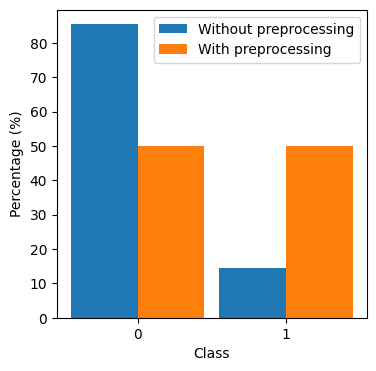

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask1_distribution")

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 5

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

In [ ]:
from transformers import TFAutoModel
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m1 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes=2, layers=layers, fine_tune=True, dropout_rate=0.2, l2_penalty=0.001)


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Summary.
m1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
from wordcloud import WordCloud, STOPWORDS
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
# Compiling.
m1.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m1, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
modified_1=m1.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids},
                  train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/5


 374/1875 [====>.........................] - ETA: 21:46 - loss: 1.0089 - accuracy: 0.6354
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:20 - loss: 0.9266 - accuracy: 0.6933
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:53 - loss: 0.8657 - accuracy: 0.7299
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:27 - loss: 0.8211 - accuracy: 0.7536
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.7745
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1642s 870ms/step - loss: 0.7838 - accuracy: 0.7746
Epoch 2/5
 374/1875 [====>.........................] - ETA: 21:45 - loss: 0.4791 - accuracy: 0.9296
The learning rate was adjusted from 1.6384e-05 t

In [ ]:
class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyCustomLayer, self).__init__()
        self.maxpool_layer = tf.keras.layers.GlobalMaxPool1D()

    def call(self, inputs):
        return self.maxpool_layer(inputs)

m1.save('/content/drive/MyDrive/modified_modelt1.h5')

In [ ]:
from transformers import TFBertModel
import tensorflow as tf
class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyCustomLayer, self).__init__()
        self.maxpool_layer = tf.keras.layers.GlobalMaxPool1D()

    def call(self, inputs):
        return self.maxpool_layer(inputs)

m1 = tf.keras.models.load_model('/content/drive/MyDrive/modified_modelt1.h5', custom_objects={'MyCustomLayer': MyCustomLayer, 'TFBertModel': TFBertModel})

In [ ]:
import numpy as np
# Validation test.
y_pred_m1 = np.argmax(m1.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("/content/drive/MyDrive/subtask1_modified_m1_pred.npy", y_pred_m1)
np.save("/content/drive/MyDrive/subtask1_modified_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m1))

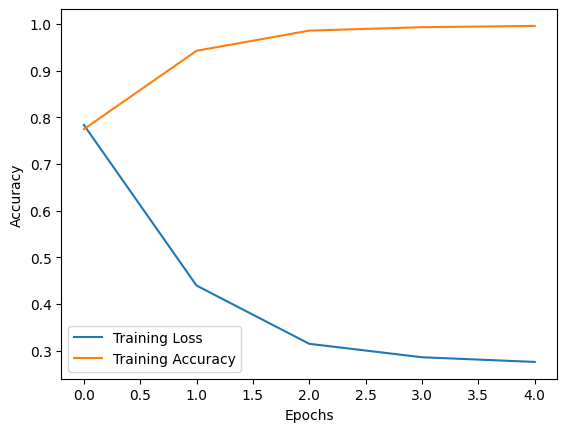

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the training history from the 'history' attribute of the 'Fit' object
loss = modified_1.history['loss']
accuracy = modified_1.history['accuracy']

# Plot the loss and accuracy graph
plt.plot(loss, label='Training Loss')
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy: ", accuracy)

from sklearn.metrics import precision_score

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
precision = precision_score(y_true, y_pred, pos_label=0)

print("Precision:", precision)
from sklearn.metrics import recall_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
recall = recall_score(y_true, y_pred, pos_label=0)

print("Recall:", recall)

from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, pos_label=0)
print("F1 score:", f1)

from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy:  0.798225128444652
Precision: 0.964403427818062
Recall: 0.7946768060836502
F1 score: 0.8713519952352591
Macro F1 score: 0.7378155610414241
Confusion Matrix:
[[1463  378]
 [  54  246]]


In [ ]:
from sklearn.metrics import recall_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
recall = recall_score(y_true, y_pred, pos_label=0)

print("Recall:", recall)


Recall: 0.815317762085823


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, pos_label=0)
print("F1 score:", f1)



F1 score: 0.8829411764705882


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1501  340]
 [  58  242]]


In [ ]:
import numpy as np

# Load predicted and true labels.
y_pred = np.load("/content/drive/MyDrive/subtask1_m1_pred (2).npy")
y_true = np.load("/content/drive/MyDrive/subtask1_m1_true.npy")

# Print contents of arrays.
print("Predicted labels:", y_pred)
print("True labels:", y_true)

Predicted labels: [0 0 1 ... 1 0 0]
True labels: [0 0 1 ... 1 0 0]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# True labels and predicted labels
y_pred = np.load("/content/drive/MyDrive/subtask1_m1_pred (2).npy")
y_true = np.load("/content/drive/MyDrive/subtask1_m1_true.npy")


# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)


Macro F1 score: 0.7378155610414241


In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 5

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

from transformers import TFAutoModel
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m2 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes=2, layers=layers, fine_tune=True, dropout_rate=0.2, l2_penalty=0.001)

# Summary.
m2.summary()


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
from wordcloud import WordCloud, STOPWORDS
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from keras.losses import SparseCategoricalCrossentropy
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
# Compiling.
m2.compile(optimizer = SGD(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m2, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
modified_2=m2.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/5


 374/1875 [====>.........................] - ETA: 20:52 - loss: 1.1875 - accuracy: 0.4880
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 15:47 - loss: 1.1731 - accuracy: 0.5029
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:33 - loss: 1.1652 - accuracy: 0.5086
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:17 - loss: 1.1575 - accuracy: 0.5139
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 1.1509 - accuracy: 0.5193
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1597s 846ms/step - loss: 1.1509 - accuracy: 0.5194
Epoch 2/5
 374/1875 [====>.........................] - ETA: 21:14 - loss: 1.1227 - accuracy: 0.5348
The learning rate was adjusted from 1.6384e-05 t

In [ ]:
class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyCustomLayer, self).__init__()
        self.maxpool_layer = tf.keras.layers.GlobalMaxPool1D()

    def call(self, inputs):
        return self.maxpool_layer(inputs)

m2.save('/content/drive/MyDrive/modified(SGD)_modelt1.h5')

In [ ]:
# Validation test.
y_pred_m2 = np.argmax(m2.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("/content/drive/MyDrive/subtask1_modified(SGD)_m2_pred.npy", y_pred_m2)
np.save("/content/drive/MyDrive/subtask1_modified(SGD)_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m2))


              precision    recall  f1-score   support

           0       0.88      0.63      0.73      1841
           1       0.17      0.48      0.26       300

    accuracy                           0.61      2141
   macro avg       0.53      0.56      0.50      2141
weighted avg       0.78      0.61      0.67      2141



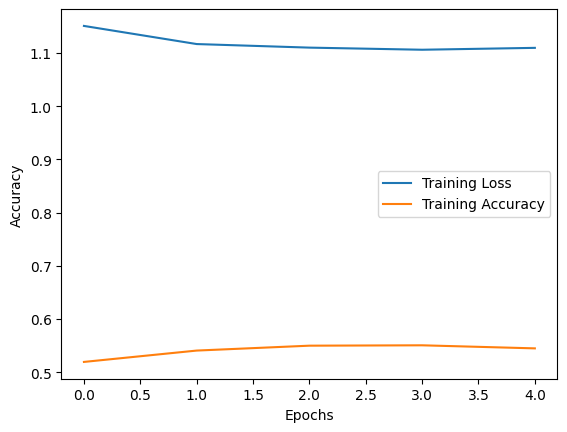

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the training history from the 'history' attribute of the 'Fit' object
loss = modified_2.history['loss']
accuracy = modified_2.history['accuracy']

# Plot the loss and accuracy graph
plt.plot(loss, label='Training Loss')
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_2, y_pred_2)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1157  684]
 [ 155  145]]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true_2, y_pred_2, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)


Macro F1 score: 0.5417922794428177


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_true_2,y_pred_2)

print("Accuracy: ", accuracy)


from sklearn.metrics import precision_score

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
precision = precision_score(y_true_2, y_pred_2, pos_label=0)

print("Precision:", precision)


from sklearn.metrics import recall_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
recall = recall_score(y_true_2, y_pred_2, pos_label=0)

print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_true_2, y_pred_2, pos_label=0)
print("F1 score:", f1)

from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true_2, y_pred_2, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_2, y_pred_2)
print("Confusion Matrix:")
print(cm)



Accuracy:  0.608127043437646
Precision: 0.881859756097561
Recall: 0.6284627919608908
F1 score: 0.7339042182048842
Macro F1 score: 0.5417922794428177
Confusion Matrix:
[[1157  684]
 [ 155  145]]


In [ ]:
import numpy as np
# Load predicted and true labels.
y_pred_2 = np.load("/content/drive/MyDrive/subtask1_modified(SGD)_m2_pred.npy")
y_true_2 = np.load("/content/drive/MyDrive/subtask1_modified(SGD)_m2_true.npy")

# Print contents of arrays.
print("Predicted labels:", y_pred_2)
print("True labels:", y_true_2)

Predicted labels: [0 1 1 ... 1 1 0]
True labels: [0 0 1 ... 1 0 0]


In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 5

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

from transformers import TFAutoModel
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m3 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes=2, layers=layers, fine_tune=True, dropout_rate=0.2, l2_penalty=0.001)

# Summary.
m3.summary()


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
from wordcloud import WordCloud, STOPWORDS
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
# Compiling.
m3.compile(optimizer = Adamax(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m3, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
modified_3=m3.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/5


 374/1875 [====>.........................] - ETA: 20:33 - loss: 1.0243 - accuracy: 0.6272
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 15:28 - loss: 0.9546 - accuracy: 0.6860
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:20 - loss: 0.9167 - accuracy: 0.7120
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:10 - loss: 0.8830 - accuracy: 0.7328
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.7481
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1561s 827ms/step - loss: 0.8577 - accuracy: 0.7481
Epoch 2/5
 374/1875 [====>.........................] - ETA: 20:41 - loss: 0.6576 - accuracy: 0.8728
The learning rate was adjusted from 1.6384e-05 t

In [ ]:
class MyCustomLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(MyCustomLayer, self).__init__()
        self.maxpool_layer = tf.keras.layers.GlobalMaxPool1D()

    def call(self, inputs):
        return self.maxpool_layer(inputs)

m3.save('/content/drive/MyDrive/modified(ADAMAX)_modelt1.h5')

In [ ]:
# Validation test.
y_pred_m3 = np.argmax(m3.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_pred.npy", y_pred_m3)
np.save("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m3))


              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1841
           1       0.42      0.85      0.56       300

    accuracy                           0.81      2141
   macro avg       0.70      0.83      0.72      2141
weighted avg       0.89      0.81      0.84      2141



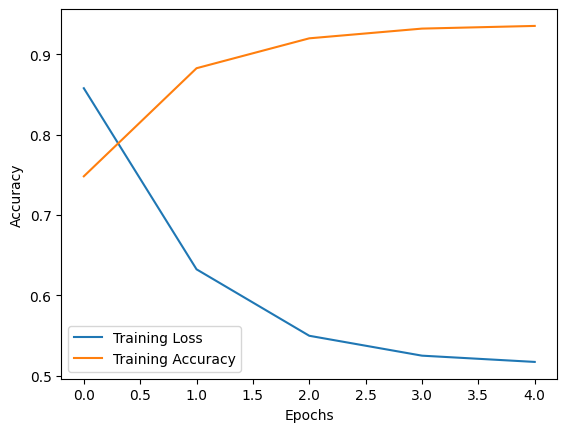

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the training history from the 'history' attribute of the 'Fit' object
loss = modified_3.history['loss']
accuracy = modified_3.history['accuracy']

# Plot the loss and accuracy graph
plt.plot(loss, label='Training Loss')
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# True labels and predicted labels
y_pred_3 = np.load("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_pred.npy")
y_true_3 = np.load("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_true.npy")


# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true_3, y_pred_3, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)


Macro F1 score: 0.7565012062832539


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_3, y_pred_3)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1489  352]
 [  45  255]]


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming y_true is the true labels and y_pred is the predicted labels
accuracy = accuracy_score(y_true_3, y_pred_3)

print("Accuracy: ", accuracy)

from sklearn.metrics import precision_score

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
precision = precision_score(y_true_3, y_pred_3, pos_label=0)

print("Precision:", precision)


from sklearn.metrics import recall_score

# Assuming y_true contains the true labels and y_pred contains the predicted labels
recall = recall_score(y_true_3, y_pred_3, pos_label=0)

print("Recall:", recall)


from sklearn.metrics import f1_score

f1 = f1_score(y_true_3, y_pred_3, pos_label=0)
print("F1 score:", f1)

from sklearn.metrics import precision_recall_fscore_support

# True labels and predicted labels
y_pred_3 = np.load("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_pred.npy")
y_true_3 = np.load("/content/drive/MyDrive/subtask1_modified(ADAMAX)_m3_true.npy")


# Compute precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true_3, y_pred_3, average=None)

# Calculate macro F1 score
macro_f1 = 2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

print("Macro F1 score:", macro_f1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_3, y_pred_3)
print("Confusion Matrix:")
print(cm)



Accuracy:  0.8145726296123307
Precision: 0.970664928292047
Recall: 0.8087995654535578
F1 score: 0.8823703703703704
Macro F1 score: 0.7565012062832539
Confusion Matrix:
[[1489  352]
 [  45  255]]
